In [1]:
import torch
import matplotlib.pyplot as plt


In [2]:
E_true = 1  # Young modulus
F_imposed = torch.linspace(0, 140, 100)  # 100 loadings uniformly distributed between 0 and 140

First, we need to create the functions to generate the data needed for training. 
To help the understanding, the Latin method (which will be adapted to perform the Step 1 of the mCRE training) is used to generate the data. 

In [3]:
  # Import of the function used to integrate evolutions laws

def generate_data(E, F_imposed):
    """
    This function simulates the true model in order to generate the data need for the training.
    Input: 
        - E: Young modulus
        - F_imposed: torch.tensor containing all the values of the imposed force at each time step.
    Output:
        - eps_elastic: elastic strain (torch.tensor containing the values at each time step)
        - sigma: stress (torch.tensor containing the values at each time step)
    """
    
   
     ## Iteration 0 (elastic initialisation)
    eps_elastic = F_imposed / E 
    sigma = E * eps_elastic

    return eps_elastic, sigma 

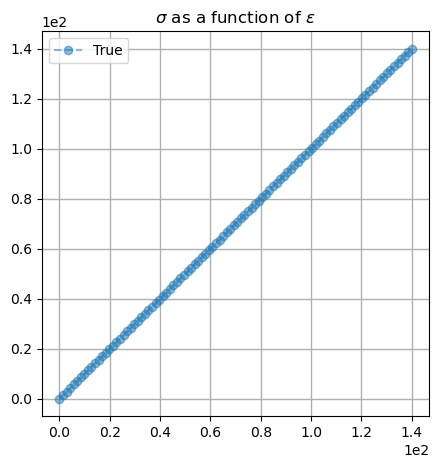

In [4]:
from plot_utils import plot_solution

eps_elastic_true, sigma_true = generate_data(E_true, F_imposed)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plot_solution(axs, sigma_true, eps_elastic_true, label='True')
plt.show()


Now, let's add some noise on the data.

In [5]:
noise_level = 1e-2

mean = torch.abs(eps_elastic_true).mean()
noise = torch.normal(std=noise_level * mean * torch.ones_like(eps_elastic_true), mean=0)
eps_elastic_true_noisy = eps_elastic_true + noise

t = 1,   E_guess = 0.8
t = 1,   sigma_points = [0.8, 0.8001, 0.7999]
t = 1,   grad_mcre = [tensor(0.0017), tensor(0.0017), tensor(0.0017)]
t = 1,   CZZ = tensor(3.0207e-06)
t = 1,   CpZ = tensor(4.2915e-06)
t = 1,   C = tensor(0.0002)


t = 2,   E_guess = tensor(0.7993)
t = 2,   sigma_points = [tensor(0.7993), tensor(0.7995), tensor(0.7992)]
t = 2,   grad_mcre = [tensor(0.0301), tensor(0.0301), tensor(0.0301)]
t = 2,   CZZ = tensor(4.8153e-05)
t = 2,   CpZ = tensor(2.6232e-05)
t = 2,   C = tensor(0.0003)


t = 3,   E_guess = tensor(0.7853)
t = 3,   sigma_points = [tensor(0.7853), tensor(0.7854), tensor(0.7851)]
t = 3,   grad_mcre = [tensor(-0.0671), tensor(-0.0670), tensor(-0.0672)]
t = 3,   CZZ = tensor(0.0002)
t = 3,   CpZ = tensor(0.0002)
t = 3,   C = tensor(0.0002)


t = 4,   E_guess = tensor(0.8652)
t = 4,   sigma_points = [tensor(0.8652), tensor(0.8653), tensor(0.8650)]
t = 4,   grad_mcre = [tensor(-0.0767), tensor(-0.0766), tensor(-0.0768)]
t = 4,   CZZ = tensor(0.0008)
t = 4,  

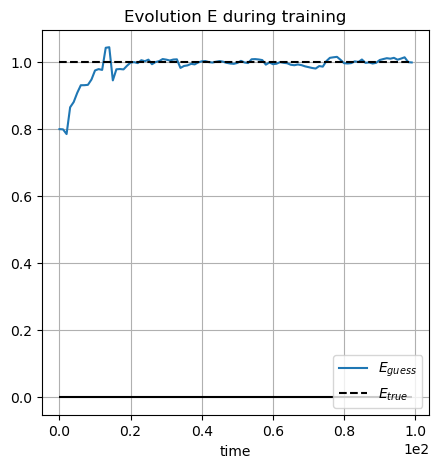

In [6]:
from utils import step_1_mcre, compute_grad_mcre
from plot_utils import plot_evolution_E_KF

import math 

# Input of the MDKF framework

L = 1  # number of parameters to update (here young modulus)
alpha_KF = 1e-2
beta = 2 # because of normal distribution assumption
E_guess = 0.8
C = 1e-4  # initial covariance on parameters
Q_p = C

alpha_mcre = 1e-2
lambda_ = (alpha_KF **2) * (L+0) - L

# weight associated with sigma point
W_0_m = lambda_ / (L+lambda_)
W_1_m = 1 / (2*(L+lambda_))
W_2_m = 1 / (2*(L+lambda_))

W_0_c = W_0_m + 1 - alpha_KF**2 + beta
W_1_c = W_1_m
W_2_c = W_2_m
weight_m = [W_0_m, W_1_m, W_2_m]
weight_c = [W_0_c, W_1_c, W_2_c]

X_0 = E_guess
X_1 = E_guess + math.sqrt((L+lambda_)*C)
X_2 = E_guess - math.sqrt((L+lambda_)*C)
sigma_points = [X_0, X_1, X_2]


# Initialisation sigma point


list_E_guess = [E_guess]
# Loop on timestep

for t in range(1, len(F_imposed)):
    # Calculationg sigma-points
    X_0 = E_guess
    X_1 = E_guess + math.sqrt((L+lambda_)*C)
    X_2 = E_guess - math.sqrt((L+lambda_)*C)
    sigma_points = [X_0, X_1, X_2]
    print(f'{t = },   {E_guess = }')
    
    # Prediction of parameter vector and associated covariance matrices 
    sigma_points_minus = sigma_points
    E_t_minus = sum(i[0] * i[1] for i in zip(sigma_points_minus, weight_m))  # weighted mean of sigma points
    diff_sigma_points_E_t_minus = [sigma_points_minus[i] - E_t_minus for i in range(0, len(sigma_points_minus))]
    C_t_minus = sum((i[0]**2) * i[1] for i in zip(diff_sigma_points_E_t_minus, weight_c)) + Q_p  # weighted mean of sigma points
    
    print(f'{t = },   {sigma_points = }')
    
    # Sigma point propagation
    grad_mcre = []
    for sigma_point in sigma_points_minus:
        eps_elastic_U, sigma_U, eps_elastic_V, sigma_V = step_1_mcre(sigma_point, F_imposed[t], eps_elastic_true_noisy[t], alpha_mcre) 
        grad_mcre.append(compute_grad_mcre(eps_elastic_U, eps_elastic_V))
    print(f'{t = },   {grad_mcre = }')
    # Prediction of observation and associated covariance matrices
    weighted_grad = sum(i[0] * i[1] for i in zip(grad_mcre, weight_m)) 
    diff_grad_weighted_grad =  [grad_mcre[i] - weighted_grad for i in range(0, len(grad_mcre))]
    CZZ = sum((i[0]**2) * i[1] for i in zip(diff_grad_weighted_grad, weight_c))  # weighted mean of sigma points
    CpZ = sum(i[0] * i[1] * i[2] for i in zip(diff_grad_weighted_grad, diff_sigma_points_E_t_minus, weight_c))  # weighted mean of sigma points
    
    # Correction 
    K_t = CpZ/CZZ
    E_guess = E_t_minus - K_t * weighted_grad
    print(f'{t = },   {CZZ = }')
    print(f'{t = },   {CpZ = }')
    C = C_t_minus - K_t * CZZ * K_t
    list_E_guess.append(E_guess)
    print(f'{t = },   {C = }')
    
    print('\n')
    
    
plot_evolution_E_KF(list_E_guess, E_true)
  